In [1]:
# Input file  
incode= """
l i1 1.0 0.0 0.0 n0
mod eo1 9e6 0.18 1 pm 0.0 n0 n1
s s1 1.0 n1 n4
m ITMX 0.9894 0.0106 0.0 n4 n5
s lp 5.560176388908762 n5 n6
m ETMX 0.999 0.001 90.0 n6 n7


pd P_Trans n4 
xaxis ETMX phi lin -180 180 1000
yaxis abs
"""
import pykat
import matplotlib.pyplot as plt
import numpy as np 
import emcee
import corner
from numpy.random import randn, rand, uniform
import matplotlib.gridspec as gridspec
from timeit import default_timer as timer
HH=12
WW=15
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'axes.grid': True})
plt.rcParams['figure.figsize'] = [HH,WW]

Baseob = pykat.finesse.kat()
Baseob.verbose = False
Baseob.parse(incode)

%matplotlib inline
# %matplotlib notebook

                                              ..-
    PyKat 1.2.81          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



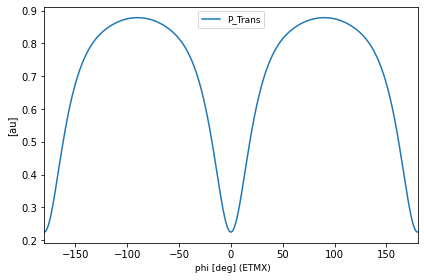

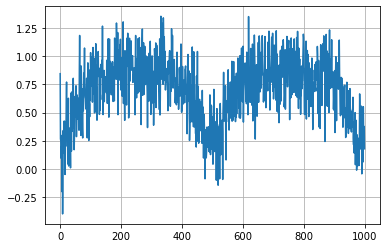

In [2]:
R1=0.3
R2=0.65
ob=Baseob.deepcopy()
ob.ITMX.R=R1
ob.ITMX.T=1-R1
ob.ETMX.R=R2
ob.ETMX.T=1-R2
# ob.lp.L=1
# ob.eo1.f=10e6
res=ob.run()
data0=res['P_Trans']

# fig = plt.figure(figsize=(11, 18))
fig=res.plot(detectors = ['P_Trans'])
# fig.show(figsize=(11, 18))
noise = np.random.randn(len(data0))*0.2
data=data0+noise
fig=plt.plot(data)

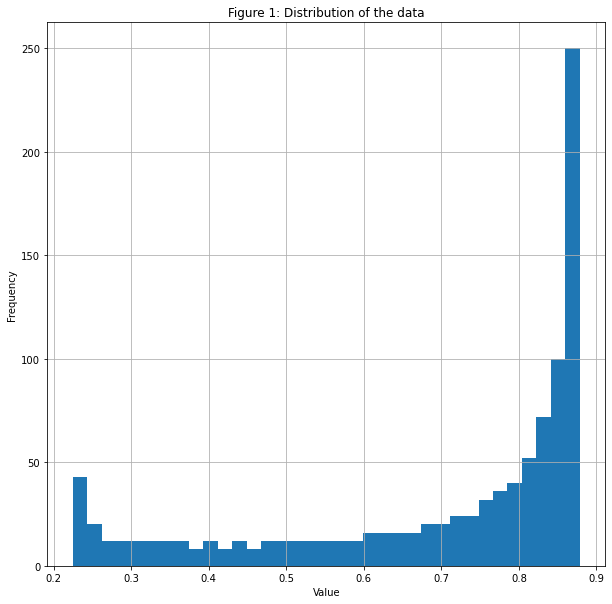

In [4]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( data0,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of the pure data")
mu_obs=data0.mean()
mu_obs
yerr=0.01*mu_obs

Text(0.5, 1.0, 'Figure 1: Distribution of the data')

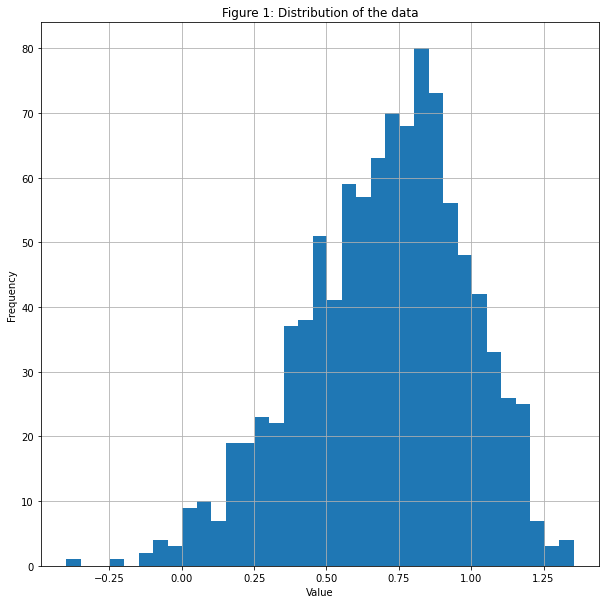

In [5]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( data,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of the noised data")


In [6]:
def signalFunction(theta):                                   ## Model
    r1,r2=theta
    ob=Baseob.deepcopy()
    ob.ITMX.R=r1
    ob.ITMX.T=1-r1
    ob.ETMX.R=r2
    ob.ETMX.T=1-r2
#     ob.lp.L=l
#     ob.eo1.f=Df
    try:
        res=ob.run()
        return res['P_Trans']
    except:
        print("An exception occurred")
        print([r1,r2])
#         print([r1 ,1-r1-d1,r2,1-r2-d2])
        return np.inf*np.ones((1001,))
            

def lnlike(theta, data,yerr):                                     ## Likelihood or probability function
    model = signalFunction(theta)
    return -0.5 * np.sum(((data - model)/yerr)**2)    

def lnprior(theta):                                              ## Initial values of parameters
    r1,r2=theta
    if 0.1 < r1 < 0.9 and  0.2 < r2 < 0.9 :
        return 0.0
#     print(theta)
    return -np.inf  

def lnpost(theta,data,yerr):                                      ## proposed values of parameter
#     print(lnprior(theta))
    if not np.isfinite(lnprior(theta)):
        return -np.inf
    return lnlike(theta,data,yerr) + lnprior(theta)

In [7]:
ndim = 2                                                         # number of parameters to estimate
nwalkers = 5                                                     # number of walkers
nsteps = 1000                                                    # number of steps each walker will take
nburn = int(nsteps/4)                                            # number of steps to "burn in"
nthreads = 5                                                     # number of parallel threads to use




initial=np.array([0.12,0.42])                                    # initial conditions

pos= [np.array(initial) + 1e-4*np.random.randn(ndim) for ii in range(nwalkers)]

print(data.shape)
# Run the sampler
t_0 = timer()
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(data,yerr), threads=nthreads)
sampler.run_mcmc(pos, nsteps)
t_elapsed = timer() - t_0
print('Elapsed time = {t:4.1f} seconds.'.format(t=t_elapsed))


(1001,)
An exception occurred
[0.2079447159011428, 0.3877220697815651]
An exception occurred
[0.1937361112809279, 0.3629360776264531]
An exception occurred
[0.6583955616221427, 0.2968763067009133]
Elapsed time = 316.3 seconds.


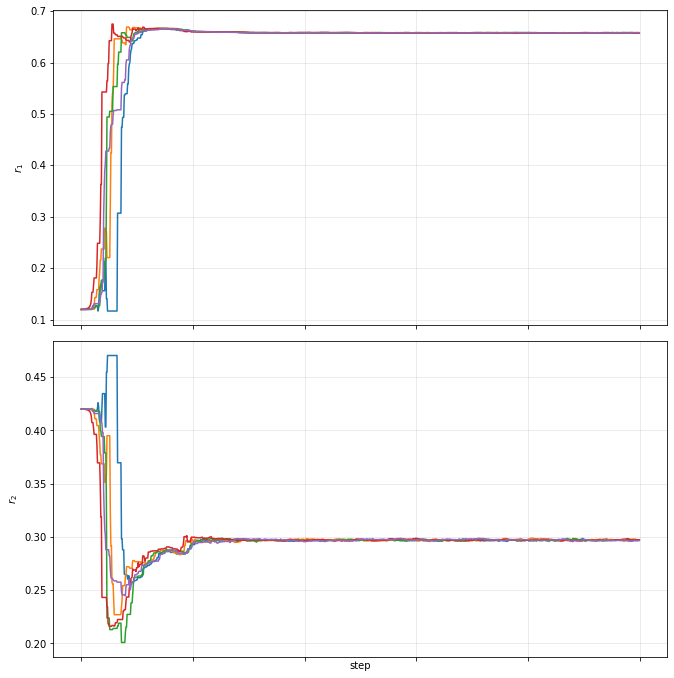

In [8]:
fig = plt.figure(figsize=(11, 18))
gs = gridspec.GridSpec(3, 1, hspace=0.05)
A_ax = fig.add_subplot(gs[0])
f_ax = fig.add_subplot(gs[1], sharex=A_ax)
for ii in range(0, nwalkers, 1):
    A_ax.plot(sampler.chain[ii, :, 0])
    f_ax.plot(sampler.chain[ii, :, 1])

plt.setp(A_ax.get_xticklabels(), visible=False)
plt.setp(f_ax.get_xticklabels(), visible=False)
A_ax.set_ylabel(r'$r_{1}$')
f_ax.set_ylabel(r'$r_{2}$')
# tau_ax.set_ylabel(r'$\tau$')
f_ax.set_xlabel('step')
# tau_ax.set_xlim(0, nsteps)
for ax in [A_ax, f_ax]:
    ax.grid('on', which='both', alpha=0.3)
    ax.grid(which='minor', alpha=0.2)

In [9]:
# Only take the samples after burning in the sampler to remove effects of initial conditions
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

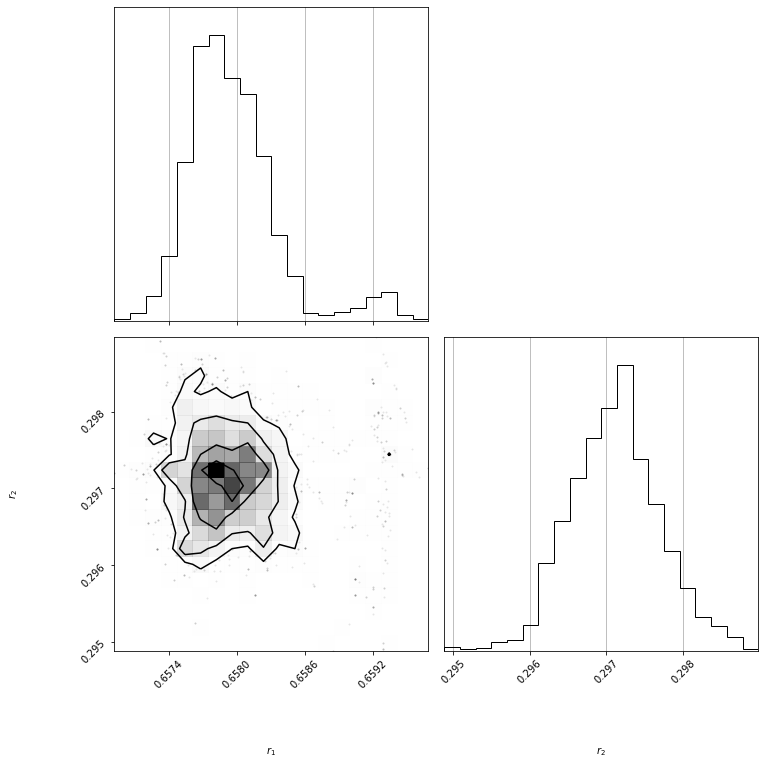

In [10]:
# Make a corner plot
fig = corner.corner(samples, labels=[r'$r_{1}$', r'$r_{2}$'], truths=[R1, R2])
fig.set_size_inches((12, 12))

In [11]:
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)


(130, 2)


In [12]:
from IPython.display import display, Math

labels = ["r1", "r2"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>